# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib torch torchvision tqdm
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image

from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict
from PIL import Image
import string
characters = '-' + string.digits + string.ascii_uppercase
width, height, n_len, n_classes = 200, 50, 6, len(characters)
n_input_length = 12
print(characters, width, height, n_len, n_classes)

-0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ 200 50 6 37


# 搭建数据集

In [2]:
import os
file_list = [x.split('.')[0] for x in  os.listdir("./img")]
#file_list = [x for x in file_list if len(x)==4 ]
random.shuffle(file_list)

In [3]:
class CaptchaDataset(Dataset):
    def __init__(self, characters, length, width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        lable = file_list.pop()
        image = to_tensor(Image.open("./img/"+lable+".jpg"))
        lable = lable.ljust(self.label_length, characters[0])
        target = torch.tensor([self.characters.find(x) for x in lable], dtype=torch.long)
        input_length = torch.full(size=(1, ), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=self.label_length, dtype=torch.long)
        return image, target, input_length, target_length

from zipfile import ZipFile
img_zip = ZipFile("img.zip")
file_list = [x.filename.split('.')[0] for x in img_zip.infolist()]
random.shuffle(file_list)

class CaptchaDataset(Dataset):
    def __init__(self, characters, length, width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        lable = file_list.pop()
        img_file = img_zip.open(lable+".jpg","r")
        image = to_tensor(Image.open(img_file).convert('RGB'))
        lable = lable.ljust(self.label_length, characters[0])
        target = torch.tensor([self.characters.find(x) for x in lable], dtype=torch.long)
        input_length = torch.full(size=(1, ), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=self.label_length, dtype=torch.long)
        return image, target, input_length, target_length

# 测试数据集

JCEAW6 tensor([12]) tensor([6])


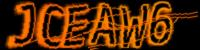

In [4]:
dataset = CaptchaDataset(characters, 1, width, height, n_input_length, n_len)
image, target, input_length, label_length = dataset[0]
print(''.join([characters[x] for x in target]), input_length, label_length)
to_pil_image(image)

# 初始化数据集生成器

In [5]:
batch_size = 128
train_set = CaptchaDataset(characters, 1000 * batch_size, width, height, n_input_length, n_len)
valid_set = CaptchaDataset(characters, 100 * batch_size, width, height, n_input_length, n_len)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=12)

# 搭建模型

In [6]:
class Model(nn.Module):
    def __init__(self, n_classes, input_shape):
        super(Model, self).__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        kernels = [3, 3, 3, 3, 3]
        pools = [2, 2, 2, 2, (2, 1)]
        modules = OrderedDict()
        
        def cba(name, in_channels, out_channels, kernel_size):
            modules[f'conv{name}'] = nn.Conv2d(in_channels, out_channels, kernel_size,
                                               padding=(1, 1) if kernel_size == 3 else 0)
            modules[f'bn{name}'] = nn.BatchNorm2d(out_channels)
            modules[f'relu{name}'] = nn.ReLU(inplace=True)
        
        last_channel = 3
        for block, (n_channel, n_layer, n_kernel, k_pool) in enumerate(zip(channels, layers, kernels, pools)):
            for layer in range(1, n_layer + 1):
                cba(f'{block+1}{layer}', last_channel, n_channel, n_kernel)
                last_channel = n_channel
            modules[f'pool{block + 1}'] = nn.MaxPool2d(k_pool)
        modules[f'dropout'] = nn.Dropout(0.25, inplace=True)
        
        self.cnn = nn.Sequential(modules)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = torch.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

## 测试模型输出尺寸

In [7]:
model = Model(n_classes, input_shape=(3, height, width))
inputs = torch.zeros((32, 3, height, width))
outputs = model(inputs)
outputs.shape

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([12, 32, 37])

## 初始化模型

In [8]:
model = Model(n_classes, input_shape=(3, height, width))
model = model.cuda()
model

Model(
  (cnn): Sequential(
    (conv11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu11): ReLU(inplace=True)
    (conv12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu12): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn21): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu21): ReLU(inplace=True)
    (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu22): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

# 解码函数和准确率计算函数

In [9]:
def decode(sequence):
    a = ''.join([characters[x] for x in sequence])
    s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(characters[0], '')

def calc_acc(target, output):
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    target = target.cpu().numpy()
    output_argmax = output_argmax.cpu().numpy()
    a = np.array([decode_target(true) == decode(pred) for true, pred in zip(target, output_argmax)])
    return a.mean()

# 训练模型

In [10]:
def train(model, optimizer, epoch, dataloader):
    model.train()
    loss_mean = 0
    acc_mean = 0
    with tqdm(dataloader) as pbar:
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss.backward()
            optimizer.step()

            loss = loss.item()
            acc = calc_acc(target, output)
            
            if batch_index == 0:
                loss_mean = loss
                acc_mean = acc
            
            loss_mean = 0.1 * loss + 0.9 * loss_mean
            acc_mean = 0.1 * acc + 0.9 * acc_mean
            
            pbar.set_description(f'Epoch: {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

def valid(model, optimizer, epoch, dataloader):
    model.eval()
    with tqdm(dataloader) as pbar, torch.no_grad():
        loss_sum = 0
        acc_sum = 0
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            output = model(data)
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss = loss.item()
            acc = calc_acc(target, output)
            
            loss_sum += loss
            acc_sum += acc
            
            loss_mean = loss_sum / (batch_index + 1)
            acc_mean = acc_sum / (batch_index + 1)
            
            pbar.set_description(f'Test : {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

In [11]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3, amsgrad=True)
epochs = 30
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

Epoch: 22 Loss: -0.4827 Acc: 0.9972 :   6%|▌         | 60/1000 [00:23<06:03,  2.59it/s]


KeyboardInterrupt: 

In [12]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4, amsgrad=True)
epochs = 5
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

Test : 5 Loss: -0.4535 Acc: 1.0000 : 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


# 测试模型输出

true: EN8CA
pred: EN8CA
true: YDTXT
pred: YDTXT
true: TEMTD
pred: TEMTD
true: EPCT5E
pred: EPCT5E
true: KKYPE
pred: KKYPE
true: RKDC
pred: RKDC
true: TM5PKU
pred: TM5PKU
true: 8CB4
pred: 8CB4
true: XCBYV9
pred: XCBYV9
true: CTJTPE
pred: CTJTPE
true: UH53VB
pred: UH53VB
true: AK389A
pred: AK389A
true: SMJADH
pred: SMJADH
true: T6JM
pred: T6JM
true: XAPWRX
pred: XAPWRX
true: 5KBE
pred: 5KBE
true: HP5J
pred: HP5J
true: 96TU
pred: 96TU
true: E63Y3
pred: E63Y3
true: TS6A
pred: TS6A
true: TU5PRV
pred: TU5PRV
true: 9V66JW
pred: 9V66JW
true: RSVC
pred: RSVC
true: V65R
pred: V65R
true: MJVK
pred: MJVK
true: 5Y9KB
pred: 5Y9KB
true: 3PH8
pred: 3PH8
true: XXVTNX
pred: XXVTNX
true: V5YX
pred: V5YX
true: 5A9J6
pred: 5A9J6
true: MPMR
pred: MPMR
true: YB3DC
pred: YB3DC
true: UJN4B
pred: UJN4B
true: W9HNMY
pred: W9HNMY
true: KTDMX
pred: KTDMX
true: VNWV
pred: VNWV
true: B5J8
pred: B5J8
true: 6X66
pred: 6X66
true: WTTPK
pred: WTTPK
true: RPMC
pred: RPMC
true: 5XSKRW
pred: 5XSKRW
true: SSHR
pred: SSHR
tr

true: 46VX
pred: 46VX
true: C5RA
pred: C5RA
true: H5VNB
pred: H5VNB
true: 55K9
pred: 55K9
true: JBHSW
pred: JBHSW
true: T8YJV
pred: T8YJV
true: RSTSB4
pred: RSTSB4
true: 9UK3W6
pred: 9UK3W6
true: KTYR3
pred: KTYR3
true: 4S3W
pred: 4S3W
true: MU4AH
pred: MU4AH
true: R9MD
pred: R9MD
true: KASYUU
pred: KASYUU
true: NRPV
pred: NRPV
true: XTYA
pred: XTYA
true: N3YC9
pred: N3YC9
true: 6AAK
pred: 6AAK
true: E6AUD
pred: E6AUD
true: CHPSYN
pred: CHPSYN
true: H4JNXX
pred: H4JNXX
true: 9CHM9
pred: 9CHM9
true: 5NMM
pred: 5NMM
true: T6TD
pred: T6TD
true: 56JH6
pred: 56JH6
true: DJPWA
pred: DJPWA
true: 3BS6N
pred: 3BS6N
true: A4B3
pred: A4B3
true: HXVUS
pred: HXVUS
true: 6KV34
pred: 6KV34
true: 9SEYN
pred: 9SEYN
true: EBUMA
pred: EBUMA
true: Y5MY
pred: Y5MY
true: 339M8M
pred: 339M8M
true: P6YYPE
pred: P6YYPE
true: 8BEEU
pred: 8BEEU
true: UJVWJM
pred: UJVWJM
true: BAE5J
pred: BAE5J
true: H3CU
pred: H3CU
true: 8NN9AH
pred: 8NN9AH
true: CEADP
pred: CEADP
true: MYSE4
pred: MYSE4
true: BN6H4Y
pred: BN6H4

pred: AVWW3
true: T53KA5
pred: T53KA5
true: YTTH6K
pred: YTTH6K
true: 4SUK3
pred: 4SUK3
true: 4EUARY
pred: 4EUARY
true: AMNUJ
pred: AMNUJ
true: 9NR8
pred: 9NR8
true: NWSH
pred: NWSH
true: U4XT
pred: U4XT
true: EJPTM
pred: EJPTM
true: 46DW4
pred: 46DW4
true: EEWHWM
pred: EEWHWM
true: TDDVW
pred: TDDVW
true: 53DT
pred: 53DT
true: HAENB
pred: HAENB
true: PVSNDR
pred: PVSNDR
true: 9HUSD3
pred: 9HUSD3
true: TXKCAN
pred: TXKCAN
true: NJXW
pred: NJXW
true: NMH85
pred: NMH85
true: RJ5SM
pred: RJ5SM
true: 9U358B
pred: 9U358B
true: BWW4UY
pred: BWW4UY
true: YCXB
pred: YCXB
true: CPAD
pred: CPAD
true: UVS9S3
pred: UVS9S3
true: 9YJHCE
pred: 9YJHCE
true: ESNEM
pred: ESNEM
true: WEJMPX
pred: WEJMPX
true: DPDBA
pred: DPDBA
true: JYYC
pred: JYYC
true: MBJV65
pred: MBJV65
true: BUJR
pred: BUJR
true: 9KEDJM
pred: 9KEDJM
true: D33UX
pred: D33UX
true: 9HR99
pred: 9HR99
true: SHJYB
pred: SHJYB
true: V8PH
pred: V8PH
true: S86UE
pred: S86UE
true: 6NJ5Y
pred: 6NJ5Y
true: HHPE
pred: HHPE
true: BAS86J
pred: BAS

true: Y9WYW9
pred: Y9WYW9
true: AC6MSW
pred: AC6MSW
true: CUECY
pred: CUECY
true: JWSHWS
pred: JWSHWS
true: T3NK
pred: T3NK
true: T5UMU
pred: T5UMU
true: HTEPNY
pred: HTEPNY
true: W8JA
pred: W8JA
true: 8AATCB
pred: 8AATCB
true: UDWC
pred: UDWC
true: 4XX4
pred: 4XX4
true: EHV6
pred: EHV6
true: SE8XHJ
pred: SE8XHJ
true: M8US
pred: M8US
true: NHJ6UJ
pred: NHJ6UJ
true: MNPW
pred: MNPW
true: V5VH
pred: V5VH
true: JN8R49
pred: JN8R49
true: TCRMAB
pred: TCRMAB
true: D3P6T9
pred: D3P6T9
true: D4M65
pred: D4M65
true: 934PA
pred: 934PA
true: 95KXYS
pred: 95KXYS
true: 5ASSKC
pred: 5ASSKC
true: UDUM
pred: UDUM
true: WYBV
pred: WYBV
true: K4B8AV
pred: K4B8AV
true: BB33
pred: BB33
true: SECV59
pred: SECV59
true: Y9T6M
pred: Y9T6M
true: ASC5
pred: ASC5
true: UAVPX
pred: UAVPX
true: RDVWA5
pred: RDVWA5
true: 3AWBMB
pred: 3AWBMB
true: STWK
pred: STWK
true: 8BTWCV
pred: 8BTWCV
true: T9WN3
pred: T9WN3
true: RCHH4
pred: RCHH4
true: N4YK
pred: N4YK
true: PNUNH
pred: PNUNH
true: EHKM
pred: EHKM
true: AS9J4K

pred: TUA5M
true: TJDUE
pred: TJDUE
true: 5KS9
pred: 5KS9
true: TWKSS9
pred: TWKSS9
true: SKUB
pred: SKUB
true: 3VUVXW
pred: 3VUVXW
true: CM3D
pred: CM3D
true: UN49B
pred: UN49B
true: CMV6
pred: CMV6
true: AYTD
pred: AYTD
true: 8D3PU
pred: 8D3PU
true: CRPH5
pred: CRPH5
true: WK9N6
pred: WK9N6
true: JEJE
pred: JEJE
true: YKCW8
pred: YKCW8
true: YCRCCJ
pred: YCRCCJ
true: DXYYV
pred: DXYYV
true: NMC9R
pred: NMC9R
true: XSJS58
pred: XSJS58
true: YJSJ
pred: YJSJ
true: UNPV
pred: UNPV
true: BNXUVK
pred: BNXUVK
true: C33MA
pred: C33MA
true: PCX3
pred: PCX3
true: BE49RB
pred: BE49RB
true: C8DTSE
pred: C8DTSE
true: NMPUB
pred: NMPUB
true: H9ND
pred: H9ND
true: N5KR5R
pred: N5KR5R
true: MJKC5
pred: MJKC5
true: HACX
pred: HACX
true: XVPVT
pred: XVPVT
true: MSPHPN
pred: MSPHPN
true: X6H5
pred: X6H5
true: MCTA
pred: MCTA
true: JNTUUJ
pred: JNTUUJ
true: CRDYY
pred: CRDYY
true: VWUVWY
pred: VWUVWY
true: PKU8HX
pred: PKU8HX
true: B8JDMA
pred: B8JDMA
true: 8NRC5D
pred: 8NRC5D
true: D984E
pred: D984E
tr

pred: XJ9MS9
true: H6U9KH
pred: H6U9KH
true: 545HT8
pred: 545HT8
true: 56RBWE
pred: 56RBWE
true: 84YNSE
pred: 84YNSE
true: TKJB
pred: TKJB
true: BABKR
pred: BABKR
true: AP9Y5
pred: AP9Y5
true: X6SAP
pred: X6SAP
true: M9SVK
pred: M9SVK
true: 59CW8
pred: 59CW8
true: E6R8PR
pred: E6R8PR
true: D859
pred: D859
true: A9M8
pred: A9M8
true: RNM8
pred: RNM8
true: YYTX
pred: YYTX
true: 4JW8X
pred: 4JW8X
true: A3WK9E
pred: A3WK9E
true: KYM4
pred: KYM4
true: 9WXU
pred: 9WXU
true: 3X6YRC
pred: 3X6YRC
true: DWKSA
pred: DWKSA
true: NKD8H
pred: NKD8H
true: PW5JH
pred: PW5JH
true: SUNPCH
pred: SUNPCH
true: HY9PC5
pred: HY9PC5
true: 6PHHXS
pred: 6PHHXS
true: DKTN
pred: DKTN
true: V5YTRN
pred: V5YTRN
true: XUC5
pred: XUC5
true: BB3SM
pred: BB3SM
true: NS8XE
pred: NS8XE
true: RKRPW9
pred: RKRPW9
true: MRS4H
pred: MRS4H
true: DPHT4
pred: DPHT4
true: U53RDV
pred: U53RDV
true: KHETN
pred: KHETN
true: 8KDM
pred: 8KDM
true: W99V
pred: W99V
true: B8R9
pred: B8R9
true: D4BYP
pred: D4BYP
true: JVBSC
pred: JVBSC
t

pred: PTH33T
true: SSNM
pred: SSNM
true: XCXPMA
pred: XCXPMA
true: U3ARD
pred: U3ARD
true: BA5T8K
pred: BA5T8K
true: TYNEMH
pred: TYNEMH
true: UEYNNH
pred: UEYNNH
true: 9P3R
pred: 9P3R
true: SXW6D
pred: SXW6D
true: 9Y4J3
pred: 9Y4J3
true: T4UTX
pred: T4UTX
true: 4JN8
pred: 4JN8
true: UE5M
pred: UE5M
true: XVRDWK
pred: XVRDWK
true: YPD4
pred: YPD4
true: XW5WB
pred: XW5WB
true: MMH5H
pred: MMH5H
true: 59VEM
pred: 59VEM
true: YC4RH
pred: YC4RH
true: CMPW
pred: CMPW
true: DJEB9
pred: DJEB9
true: VAKBC
pred: VAKBC
true: 6DMS3X
pred: 6DMS3X
true: PBVSC
pred: PBVSC
true: 4495CY
pred: 4495CY
true: PX8D
pred: PX8D
true: RHJRT
pred: RHJRT
true: H63C
pred: H63C
true: VT68T9
pred: VT68T9
true: TY43T
pred: TY43T
true: M4MVU
pred: M4MVU
true: UWJ64
pred: UWJ64
true: 4HVDY
pred: 4HVDY
true: 36W3T
pred: 36W3T
true: S8JU6H
pred: S8JU6H
true: ATEN
pred: ATEN
true: PRT3BX
pred: PRT3BX
true: W36SAP
pred: W36SAP
true: 39CKM
pred: 39CKM
true: HPXKU
pred: HPXKU
true: TKYT
pred: TKYT
true: TMVCVH
pred: TMVCVH

true: A8D9
pred: A8D9
true: Y4PA
pred: Y4PA
true: MWNMV
pred: MWNMV
true: CY4ASA
pred: CY4ASA
true: PKCTY
pred: PKCTY
true: NU9P3
pred: NU9P3
true: D8A9BX
pred: D8A9BX
true: 8KMV3
pred: 8KMV3
true: JTHMVA
pred: JTHMVA
true: NDHN
pred: NDHN
true: 6KDKYB
pred: 6KDKYB
true: EX9BCD
pred: EX9BCD
true: CVP584
pred: CVP584
true: 9K8H
pred: 9K8H
true: BSTSX6
pred: BSTSX6
true: 5PK3
pred: 5PK3
true: HR4C
pred: HR4C
true: 3E3JJB
pred: 3E3JJB
true: WMJK
pred: WMJK
true: 565S
pred: 565S
true: HBHE
pred: HBHE
true: 5R9SP
pred: 5R9SP
true: M6TX95
pred: M6TX95
true: 8UPH53
pred: 8UPH53
true: XVDC3A
pred: XVDC3A
true: AJWY
pred: AJWY
true: V8WH96
pred: V8WH96
true: DC4A4
pred: DC4A4
true: 5B4K
pred: 5B4K
true: SMT8N8
pred: SMT8N8
true: PMR6
pred: PMR6
true: EJE3
pred: EJE3
true: M46THK
pred: M46THK
true: 88SRP5
pred: 88SRP5
true: KHEN6
pred: KHEN6
true: WEJS
pred: WEJS
true: P9E4R
pred: P9E4R
true: UU5SC
pred: UU5SC
true: HD49
pred: HD49
true: EUSR
pred: EUSR
true: KMXA9S
pred: KMXA9S
true: M3WNT
pred

true: 3MHKN8
pred: 3MHKN8
true: J9CY
pred: J9CY
true: PJY8
pred: PJY8
true: HHTTP
pred: HHTTP
true: S8HC
pred: S8HC
true: 5BR8
pred: 5BR8
true: RYEBY
pred: RYEBY
true: 9BK9M
pred: 9BK9M
true: 3DKK6R
pred: 3DKK6R
true: E353A
pred: E353A
true: PPVS
pred: PPVS
true: MEN5
pred: MEN5
true: SY6J4
pred: SY6J4
true: K8HA
pred: K8HA
true: DVAE4Y
pred: DVAE4Y
true: PHJP8
pred: PHJP8
true: WB5T
pred: WB5T
true: VUHAXY
pred: VUHAXY
true: K66J
pred: K66J
true: 3BJ9X
pred: 3BJ9X
true: 9U9XK9
pred: 9U9XK9
true: N8KANR
pred: N8KANR
true: 956SKH
pred: 956SKH
true: BNUD
pred: BNUD
true: 4BSRP
pred: 4BSRP
true: 9MK8RS
pred: 9MK8RS
true: X65UK5
pred: X65UK5
true: EURX
pred: EURX
true: 3VXSUA
pred: 3VXSUA
true: 6VMVA
pred: 6VMVA
true: NCXAVU
pred: NCXAVU
true: BTBAJ
pred: BTBAJ
true: 8AMN6
pred: 8AMN6
true: VP83Y
pred: VP83Y
true: ENXV99
pred: ENXV99
true: KNJRH3
pred: KNJRH3
true: KD4ADU
pred: KD4ADU
true: RAHVU
pred: RAHVU
true: E354
pred: E354
true: U9HVS9
pred: U9HVS9
true: EW3EDS
pred: EW3EDS
true: TH

true: 9BS88D
pred: 9BS88D
true: 9BEN
pred: 9BEN
true: S9BHB9
pred: S9BHB9
true: A4D3
pred: A4D3
true: 94KVB
pred: 94KVB
true: S44M9
pred: S44M9
true: 8RVB
pred: 8RVB
true: 5RSJYR
pred: 5RSJYR
true: UCB6
pred: UCB6
true: Y336X
pred: Y336X
true: B5NU5A
pred: B5NU5A
true: TJ55HY
pred: TJ55HY
true: BUWR
pred: BUWR
true: HXUSY
pred: HXUSY
true: 3XEAW
pred: 3XEAW
true: SPWHAP
pred: SPWHAP
true: 8NSNTX
pred: 8NSNTX
true: MEPD
pred: MEPD
true: YN6WER
pred: YN6WER
true: 49EAAJ
pred: 49EAAJ
true: 9BD8KE
pred: 9BD8KE
true: R4WB
pred: R4WB
true: YWDUJ
pred: YWDUJ
true: Y9UC3E
pred: Y9UC3E
true: 9AA5WB
pred: 9AA5WB
true: UWAC
pred: UWAC
true: WH95N
pred: WH95N
true: ASV3
pred: ASV3
true: PSV5PB
pred: PSV5PB
true: HHP6WS
pred: HHP6WS
true: A35EA
pred: A35EA
true: 49BN
pred: 49BN
true: 6P5UN
pred: 6P5UN
true: 49EYW
pred: 49EYW
true: SP8V
pred: SP8V
true: P8TM
pred: P8TM
true: KPYU
pred: KPYU
true: D3KC9
pred: D3KC9
true: 5PX9Y4
pred: 5PX9Y4
true: 5WW59X
pred: 5WW59X
true: R3498
pred: R3498
true: 8S5P

true: 5VJDP6
pred: 5VJDP6
true: 55K5V
pred: 55K5V
true: CJ6V
pred: CJ6V
true: 946C64
pred: 946C64
true: JN69Y
pred: JN69Y
true: B5J4
pred: B5J4
true: D48NV
pred: D48NV
true: JABHNA
pred: JABHNA
true: AP5R85
pred: AP5R85
true: J9H8
pred: J9H8
true: VRKY
pred: VRKY
true: CWKKVN
pred: CWKKVN
true: P6DC3
pred: P6DC3
true: VSXHKW
pred: VSXHKW
true: BWVYN
pred: BWVYN
true: 6NNX
pred: 6NNX
true: B39XU
pred: B39XU
true: EWEXU
pred: EWEXU
true: MCN8
pred: MCN8
true: 3HD4CJ
pred: 3HD4CJ
true: KREU
pred: KREU
true: K46D6
pred: K46D6
true: V55N
pred: V55N
true: RS86W
pred: RS86W
true: EPJ8V
pred: EPJ8V
true: 8JWTKX
pred: 8JWTKX
true: 8A9PU
pred: 8A9PU
true: R449T
pred: R449T
true: S48N
pred: S48N
true: V6YU
pred: V6YU
true: MK4J
pred: MK4J
true: HHNAK
pred: HHNAK
true: XNBB
pred: XNBB
true: 9TM9
pred: 9TM9
true: RSMK
pred: RSMK
true: HSVDAM
pred: HSVDAM
true: DDC8
pred: DDC8
true: CUCS5H
pred: CUCS5H
true: MUX3
pred: MUX3
true: 6DERJX
pred: 6DERJX
true: 4A5UCR
pred: 4A5UCR
true: D8JMY
pred: D8JMY


pred: PT6MH
true: PKNP6R
pred: PKNP6R
true: PJSK
pred: PJSK
true: 89KY
pred: 89KY
true: M4YMX
pred: M4YMX
true: YASJEH
pred: YASJEH
true: 4XMS
pred: 4XMS
true: TNJPUN
pred: TNJPUN
true: K4489
pred: K4489
true: HCB5
pred: HCB5
true: P3W8
pred: P3W8
true: EVX5
pred: EVX5
true: MMYNP5
pred: MMYNP5
true: UTM9E
pred: UTM9E
true: SHH5R
pred: SHH5R
true: 8643J
pred: 8643J
true: MT98K
pred: MT98K
true: Y8WARM
pred: Y8WARM
true: RB4VW
pred: RB4VW
true: U8DY
pred: U8DY
true: AY9NY
pred: AY9NY
true: RPVJCH
pred: RPVJCH
true: EW535B
pred: EW535B
true: TK3Y
pred: TK3Y
true: 3UB4
pred: 3UB4
true: 98VT3
pred: 98VT3
true: JKWAA
pred: JKWAA
true: YNWH9T
pred: YNWH9T
true: 6TR9BT
pred: 6TR9BT
true: 9T98A
pred: 9T98A
true: 8W3DMC
pred: 8W3DMC
true: 8PJ6WY
pred: 8PJ6WY
true: SJHR
pred: SJHR
true: 8M9M98
pred: 8M9M98
true: SEJ5MB
pred: SEJ5MB
true: YHKD
pred: YHKD
true: J3S4
pred: J3S4
true: 5C3B
pred: 5C3B
true: XNAH
pred: XNAH
true: HX4C
pred: HX4C
true: WBADU
pred: WBADU
true: J3X5M
pred: J3X5M
true: P8

true: RXHJS
pred: RXHJS
true: UHCAUP
pred: UHCAUP
true: 5KD3
pred: 5KD3
true: NREH
pred: NREH
true: SK6E
pred: SK6E
true: PP6EKJ
pred: PP6EKJ
true: 9RATW
pred: 9RATW
true: 4EEB9
pred: 4EEB9
true: TW3V
pred: TW3V
true: 6UA3W
pred: 6UA3W
true: J8RDU
pred: J8RDU
true: 4CK3U
pred: 4CK3U
true: REU9
pred: REU9
true: XJN6
pred: XJN6
true: WVP58B
pred: WVP58B
true: YUNNK
pred: YUNNK
true: UT3EUR
pred: UT3EUR
true: HHNJ6X
pred: HHNJ6X
true: 46KB
pred: 46KB
true: P3DT
pred: P3DT
true: TVUE
pred: TVUE
true: A89B
pred: A89B
true: DNANP
pred: DNANP
true: 9XB6T
pred: 9XB6T
true: UMYWSS
pred: UMYWSS
true: MJMDU
pred: MJMDU
true: SMT6
pred: SMT6
true: VWXPV
pred: VWXPV
true: DWV6HJ
pred: DWV6HJ
true: PSSDX3
pred: PSSDX3
true: 8JM4N
pred: 8JM4N
true: SDDU
pred: SDDU
true: JCRP
pred: JCRP
true: AD9D
pred: AD9D
true: TPHNA
pred: TPHNA
true: 3UA8
pred: 3UA8
true: TCTM
pred: TCTM
true: NPKW
pred: NPKW
true: TV8DJ9
pred: TV8DJ9
true: AMHJ5
pred: AMHJ5
true: 9KRJH
pred: 9KRJH
true: 8EMWVW
pred: 8EMWVW
true: 

pred: YWW3N6
true: VMCNU3
pred: VMCNU3
true: 4A5X9S
pred: 4A5X9S
true: 6CTEK
pred: 6CTEK
true: YSMHA
pred: YSMHA
true: UX95W
pred: UX95W
true: WYYWA
pred: WYYWA
true: AM8A
pred: AM8A
true: WA348
pred: WA348
true: XPU4
pred: XPU4
true: 85BNNS
pred: 85BNNS
true: AC9KM
pred: AC9KM
true: J4ACX8
pred: J4ACX8
true: KKR5
pred: KKR5
true: U9U3H
pred: U9U3H
true: CDEB
pred: CDEB
true: BMK56S
pred: BMK56S
true: 3DT4R3
pred: 3DT4R3
true: JBAX
pred: JBAX
true: UNEKH
pred: UNEKH
true: ATNTTX
pred: ATNTTX
true: K9PH
pred: K9PH
true: XY4UP5
pred: XY4UP5
true: WAAVYD
pred: WAAVYD
true: PV5X
pred: PV5X
true: D5KE
pred: D5KE
true: WRTCTA
pred: WRTCTA
true: 5NY4
pred: 5NY4
true: 5VE369
pred: 5VE369
true: X9ETMA
pred: X9ETMA
true: 9XCCHH
pred: 9XCCHH
true: 9E5H
pred: 9E5H
true: 5WRYY
pred: 5WRYY
true: M4EE9D
pred: M4EE9D
true: SHVX
pred: SHVX
true: 9BAEE
pred: 9BAEE
true: BHDP3
pred: BHDP3
true: YAJV4J
pred: YAJV4J
true: YWJD
pred: YWJD
true: VTKTK
pred: VTKTK
true: 5HKNN
pred: 5HKNN
true: 6VHY5K
pred: 6V

true: R3C3
pred: R3C3
true: YETJH
pred: YETJH
true: VDUN3
pred: VDUN3
true: UUK6
pred: UUK6
true: E8BW
pred: E8BW
true: SPUWR6
pred: SPUWR6
true: AHS3SJ
pred: AHS3SJ
true: E8Y6
pred: E8Y6
true: EMVAY
pred: EMVAY
true: 8PPNXR
pred: 8PPNXR
true: 9WYSK
pred: 9WYSK
true: H5U6
pred: H5U6
true: 99R9WY
pred: 99R9WY
true: 9TAUTK
pred: 9TAUTK
true: RCAC3B
pred: RCAC3B
true: JJTT
pred: JJTT
true: 39AJBY
pred: 39AJBY
true: 454T
pred: 454T
true: WYTK
pred: WYTK
true: ARD4C
pred: ARD4C
true: EAW9
pred: EAW9
true: TV9PJP
pred: TV9PJP
true: 9CBSAH
pred: 9CBSAH
true: REJ3DX
pred: REJ3DX
true: MRJ6
pred: MRJ6
true: MCHMS
pred: MCHMS
true: DBE5W6
pred: DBE5W6
true: R43PTU
pred: R43PTU
true: BM5SUD
pred: BM5SUD
true: KJ63
pred: KJ63
true: 9YR9J
pred: 9YR9J
true: CU6TTY
pred: CU6TTY
true: 39XUHY
pred: 39XUHY
true: DCED8
pred: DCED8
true: U9YXV
pred: U9YXV
true: HJMWVX
pred: HJMWVX
true: VWT4X
pred: VWT4X
true: UBVN
pred: UBVN
true: UPKP3
pred: UPKP3
true: NY98
pred: NY98
true: HBYUP
pred: HBYUP
true: EWPP

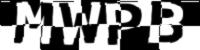

In [14]:
model.eval()
do = True
while do or decode_target(target) == decode(output_argmax[0]):
    do = False
    image, target, input_length, label_length = dataset[0]
    print('true:', decode_target(target))

    output = model(image.unsqueeze(0).cuda())
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    print('pred:', decode(output_argmax[0]))
to_pil_image(image)

In [15]:
torch.save(model, 'ctc.pth')